In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)


def loadData(filename):
    '''
    Read fits data
    
    '''
    tchfits = fits.open(filename)
    tabl = tchfits[1].data
    return tabl

## Read Coma cluster data

1316.8409611736695


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


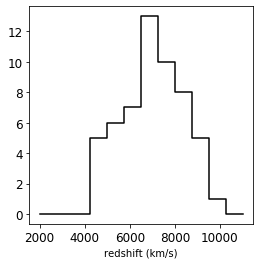

In [2]:
'''
读入数据
cz：红移×光速 = 速度
sqrt(sig_cz)：速度弥散
这一步的主要目的：查看数据范围
'''

## the mean redshift of Coma cluster
filename = 'ComaCluster.fits'
coma = loadData(filename)
cz = coma.czA[(coma.czA<20000) & (coma.czA>0)]
sig_cz = np.var(cz)
print(np.sqrt(sig_cz))
czgrid =np.arange(2000.,12000.,750.)
h, xedge = np.histogram(cz, bins=czgrid)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.step(czgrid[:-1],h,'k',where='post')
ax.set_xlabel('redshift (km/s)')
fig.show()

## Random sampling with non-informative prior
First, draw $\sigma$ from $p(\sigma^2|y) \sim {\rm Inv-\chi^2}(n-1,s^2)$.

Then, for each $\sigma$, draw $\mu$ from $p(\mu|y,\sigma^2) \sim {\rm N}(\bar{y},\sigma^2/n)$.

y_bar = 7004.745 km/s,  s2 = 1766182.527 km^2/s^2 s = 1328.978 km/s
N= 16954


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


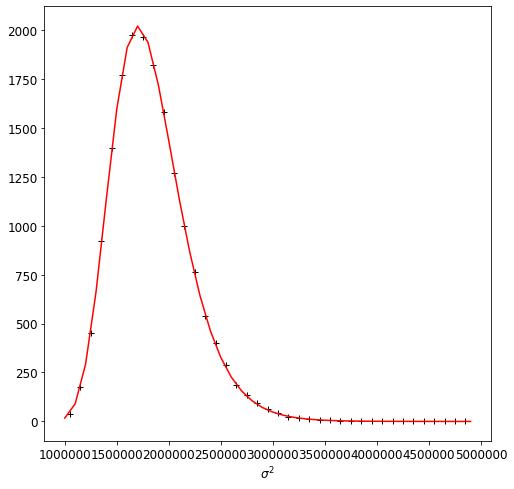

In [3]:
#ask for the mean velocity and the velocity dispersion, 
#providing that the velocity distributionis Gaussian
#known mean redshift ask dispersion, as homework

'''
随机抽样
无信息的先验分布
抽取sigma2：拒绝抽样
'''

def logit(x):
    return np.log10(x/(1.-x))

def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x

def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N):
    x = []
    k = 0
    m = 0
    while k<N and m <= 100:
        x0 = np.random.uniform(low=1e5,high=10e6,size=N*20)
        y0 = np.log(np.random.uniform(\
                    low=0,high=0.006,size=N*20))
        #x0 = logit(x0)
        y1 = Scl_InvChi2ln(x0, nu, s2)
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print(k,m,len(np.array(x)))
    x2 = np.concatenate(x)
    xx = np.array(x2).reshape((k,1))
    
    return (xx[0:N])

# sampling

y = cz

n = len(y)
y_bar = np.sum(y)/n #np.mean(y)
s2 = np.sum((y-y_bar)**2)/(n-1.) #np.var(y)
print(r'y_bar = %(y).3f km/s,  s2 = %(s).3f km^2/s^2 s = %(s1).3f km/s' %\
     {'y':y_bar, 's':s2, 's1':np.sqrt(s2)})
#step 1: draw sigma2 from posterior density of 
#        sigma2 given v, p(sigma2|y)
N = 500000
sigma2 = randDraw_SInvChi2(n-1,s2, N)
print("N=",len(sigma2))
#draw the random draw of sigma
x = np.arange(1e6,0.5e7,1e5)
y1 = np.exp(Scl_InvChi2ln(x, n-1, s2))
hy,xedge = np.histogram(sigma2,x)

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot((x[1:]+x[:-1])/2.,hy,'k+')
ax.plot(x,y1/sum(y1)*sum(hy),'r')
ax.set_xlabel(r'$\sigma^2$',fontsize=12)
fig.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


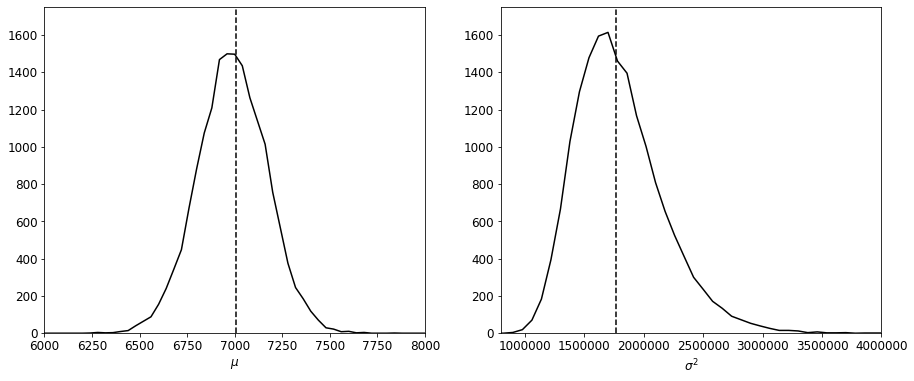

In [4]:
#step 2 : draw mu from p(mu|sigma2,y)

'''
抽取mu
竖线：数据给出的值
'''

mu = np.random.normal(loc=y_bar, \
            scale=np.sqrt(sigma2/n))
#step 3: marginalize over sigma2
#draw the random draw of sigma
x = np.arange(0,10000,40)
hy,xedge = np.histogram(mu,x)
s = np.arange(1e5,1e7,0.8e5)
hs,xedge = np.histogram(sigma2,s)

#draw the marginal density for mu
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(121)
ax.plot(x[0:-1],hy,'k')
ax.plot(y_bar*np.array([1.,1.]),[0.,10000.],'k--')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_xlim([6000,8000])
ax.set_ylim([0,1750])

#draw the marginal density for sigma
ax = fig.add_subplot(122)
ax.plot(s[0:-1],hs,'k')
ax.plot(s2*np.array([1.,1.]),[0,1e7],'k--')
ax.set_xlabel(r'$\sigma^2$',fontsize=12)
ax.set_xlim([0.8e6,4e6])
ax.set_ylim([0,1750])
fig.show()

In [5]:
#obtain the statistics from the sampling

'''
数据读出
'''

print('mu = %(m).3f+/-%(s).3f km/s, comparing to data statistics: y_bar = %(yb).3f km/s' % \
    {'m': np.mean(mu), 's': np.std(mu),'yb':y_bar})
print('sigma = %(m).3f+/-%(s).3f km/s, comparing to data statistics: s = %(s1).3f km/s' % \
    {'m': np.mean(np.sqrt(sigma2)), 's': np.std(np.sqrt(sigma2)),'s1':np.sqrt(s2)})

mu = 7007.391+/-181.038 km/s, comparing to data statistics: y_bar = 7004.745 km/s
sigma = 1348.216+/-132.818 km/s, comparing to data statistics: s = 1328.978 km/s


## Draw the joint distribution 
$p(\mu,\sigma^2|y)$

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'color'
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


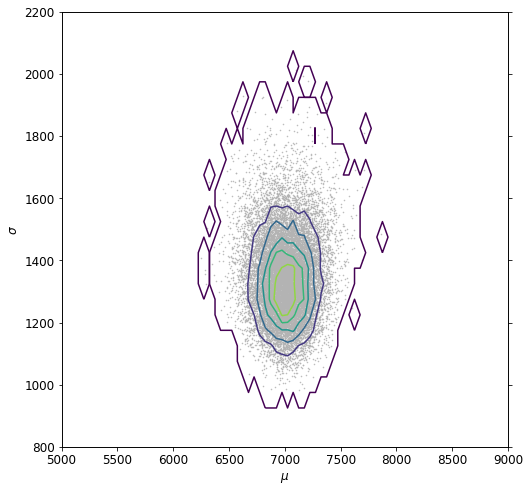

In [6]:
#draw joint posterior distribution for (mu, sigma)
xgrid = np.arange(5000,10000,50)
ygrid = np.arange(800,2500,50)
xcenter = (xgrid[:-1]+xgrid[1:])/2,
ycenter = (ygrid[:-1]+ygrid[1:])/2,
xmesh, ymesh = np.meshgrid(xcenter, ycenter)

hmusig,xedge,yedge = \
    np.histogram2d(mu.reshape((len(mu),)), \
    np.sqrt(sigma2.reshape((len(sigma2),))), \
    bins=[xgrid,ygrid])

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.plot(mu,np.sqrt(sigma2),'.',\
    color=[0.7,0.7,0.7],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,color='r',\
            extent=[xcenter[0],xcenter[-1],\
            ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),\
            np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=12)
ax.set_xlim([5000,9000])
ax.set_ylim([800,2200])
ax1.set_xlim([5000,9000])
ax1.set_ylim([800,2200])
ax1.set_yticklabels([])

fig.show()

'''
分布：对mu对称，对sigma不对称，二者无明显相关性
'''

## consider a conjugate prior with hyperparameters:
$\kappa_0=10$, $\nu_0=9$, $\mu_0=6925$ km s$^{-1}$, $\sigma_0=1000$ km s$^{-1}$

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: The following kwargs were not used by contour: 'color'
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: The following kwargs were not used by contour: 'color'
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


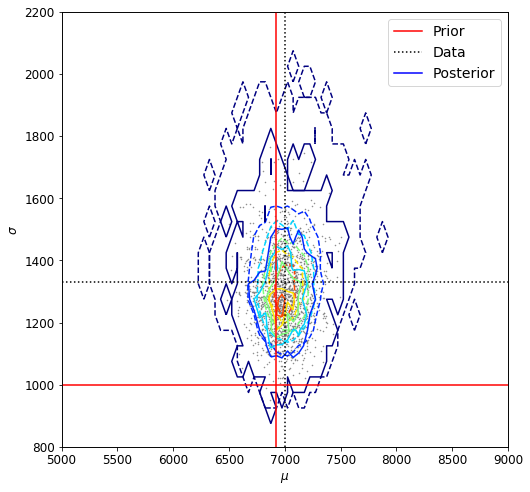

In [7]:
# consider a conjugate prior

'''
共轭先验分布（此处超参数为假设值，实际使用需要查阅资料）
使用公式计算 mu_n, kappa_n, nu_n, nu_n*sigma_n^2
'''

import matplotlib.lines as mlines
#parameters of prior
mu0 = 6925.
sigma02 = 1000.**2
kappa0 = 10
nu0 = 9

n = np.float(len(y))
N = 50000

#sample mean and variance
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+\
    kappa0*n*(y_bar-mu0)**2/(kappa0+n)

#step 1: sample sigma2
sigma2_c = randDraw_SInvChi2(nun,\
            nunsigman2/nun, N)
#step 2: sample mu
mu_c = np.random.normal(mun,np.sqrt(sigma2_c/kappan))

#draw joint distribution obtained 
# from the sampling
hmusig_c,xedge,yedge = np.histogram2d(\
    mu_c.reshape((len(mu_c),)), \
    np.sqrt(sigma2_c.reshape(\
        (len(sigma2_c),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[8,8])
plt.set_cmap('jet')
ax = fig.add_subplot(111)
ax.plot(mu_c,np.sqrt(sigma2_c),'.',\
        color=[0.5,0.5,0.5],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,\
            linestyles='dashed',\
            color='r',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ax1.contour(xmesh,ymesh,hmusig_c.T,6,\
            color='k',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ct = mlines.Line2D([], [], color='blue')
e0,= ax1.plot([mu0,mu0],[800,2200],'r-')
ax1.plot([5000,9000],[np.sqrt(sigma02),\
            np.sqrt(sigma02)],'r-')
e1, =ax1.plot([y_bar,y_bar],[800,2200],'k:')
ax1.plot([5000,9000],[np.sqrt(s2),\
            np.sqrt(s2)],'k:')
plt.legend([e0,e1,ct],['Prior','Data','Posterior'],fontsize=14)
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=12)
ax.set_xlim([5000,9000])
ax.set_ylim([800,2200])
ax1.set_xlim([5000,9000])
ax1.set_ylim([800,2200])
ax1.set_yticks([])

fig.show()

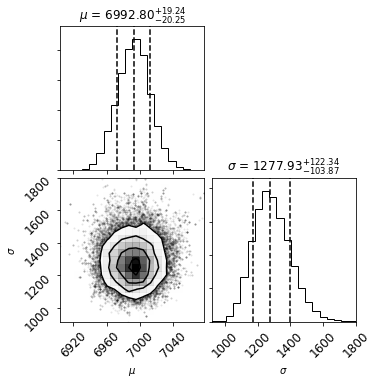

In [8]:
import emcee
import corner

def N_Scl_invChi2ln(x, mu,nu,kappa,sigma2):
    if x[1]<0:
        return -1e50
    else:
        return Scl_InvChi2ln(x[1]**2,\
            nu,sigma2)+stats.norm.logpdf(x[0],\
            loc=mu, scale=x[1]/kappa)

'''
MCMC
直接构造 p(mu,sigma^2|y) 的概率分布
'''

# n = np.float(len(y))

# #sample mean and variance
# y_bar = np.sum(y)/n
# s2 = np.sum((y-y_bar)**2)/(n-1)


#parameters of the posterior density
# mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
# kappan = kappa0+n
# nun = nu0+n
# nunsigman2 = nu0*sigma02+(n-1)*s2+kappa0*n*\
#     (y_bar-mu0)**2/(kappa0+n)
sigman2 = nunsigman2/nun

ndim = 2

nwalkers = 50

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*2000.+6000.
p0[:,1] = np.random.rand(nwalkers)*2500+500
    
sampler = emcee.EnsembleSampler(nwalkers, \
    ndim, N_Scl_invChi2ln, \
    args=[mun,nun,kappan,sigman2])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

samples = sampler.chain[:, :, :].reshape((-1, ndim))

fig = corner.corner(samples,\
        labels=[r"$\mu$", r"$\sigma$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


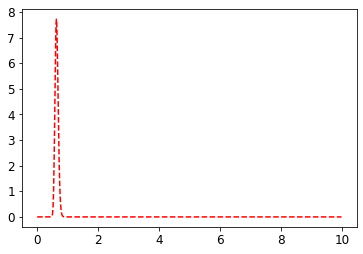

In [9]:
%matplotlib inline
'''
Demonstrate why we use log-Inv-Gamma rather than Inve-Gamma
'''
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

def InvGamma(x,alpha,beta):
    return beta**alpha/special.gamma(alpha)*\
           x**(-alpha-1)*np.exp(-beta/x)
    
def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x
    
alpha = 155.
beta = 100.
xgrid = np.arange(0,10,0.01)
# y = InvGamma(xgrid,alpha,beta) # report error: Result too large
lny = InvGammaln(xgrid,alpha,beta)

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(xgrid,y,'k-')
ax.plot(xgrid,np.exp(lny),'r--')

fig.show()

In [10]:
'''
Demonstrate how to deal with extremely small numbers
'''
x1 = -1991.
x2 = -1993.
s = 0.1
y1 = np.exp(-x1/(2*s**2))
y2 = np.exp(-x2/(2*s**2))
print(y1/y2)
y1 = -x1/(2*s**2)
y2 = -x2/(2*s**2)
print((y1-y2))
print(np.exp(y1-y2+100))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


nan
-100.0
1.0


In [11]:
from astropy.io import ascii
data = ascii.read("RV.csv", format='csv', fast_reader=False)
print(data)

     HJD           phase         RV_gamma    RV_gamma_error
------------- --------------- -------------- --------------
458861.950953   0.87349055129  136.992581692  1.28559580003
458861.965093  0.890606625815  118.682277421  1.58718125535
458861.979234   0.90772272816    97.86781377  1.36934774723
457879.078373  0.189771680644 -182.695760389  1.77404725897
458923.205045 0.0163623808953 -23.1758837427  1.18151449785
458923.225947 0.0416631126096 -52.4117378928  1.28353173567
458924.242971  0.272684417922 -201.948492407  3.43552167141
458924.263874  0.297985117949 -189.133256869  3.95207420905
458926.186172  0.624764195082  120.008654431  2.37955764465
458930.364106  0.681797845796  150.876659125  7.91795778954
458931.275117  0.784499100049  169.974674742 0.989573886733


## fit radial velocity curve to a binary star
physical model: $RV=K\cos(2\pi p+\theta_0)$

Bayesian model: $p(K, \theta_0|RV)\propto p(RV|K,\theta_0)p(K,\theta_0)$

$p(RV|K, \theta_0)\propto \exp\left[-\frac{\sum_{i}^{n}{(RV_i-(K\cos(2\pi p_i+\theta_0))^2}}{2\sigma_i^2}\right]$

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


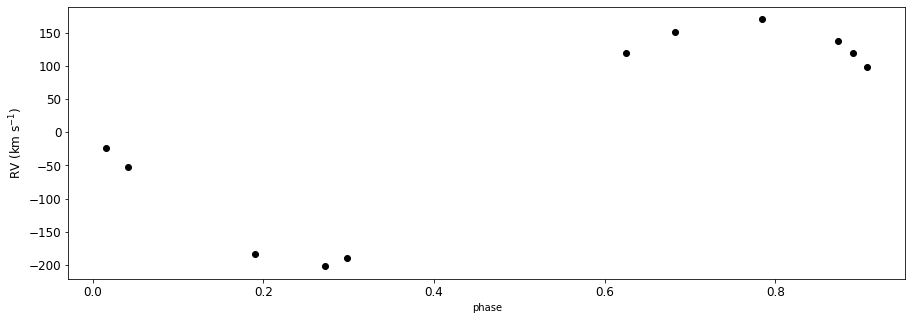

In [12]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
ax.plot(data['phase'],data['RV_gamma'],'ko')
ax.set_ylabel(r'RV (km s$^{-1}$)',fontsize=12)
ax.set_xlabel(r'phase')
fig.show()

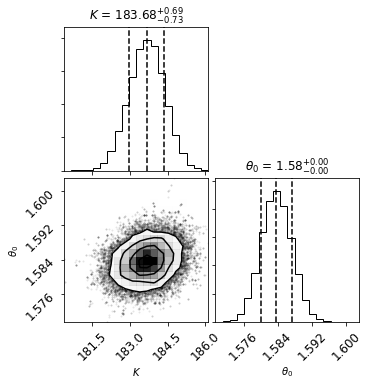

In [13]:
import emcee
import corner

def RV_eq(ph,K, theta0):
    return K*np.cos(2.*np.pi*ph+theta0)

def lnprob(x, ph, RV,RVerr):
    K = x[0]
    theta0 = x[1]
    if (K<0) or (K>400.) or (theta0<-0) or (theta0>np.pi):
        return -1e50
    else:
        return -np.sum((RV-RV_eq(ph,K,theta0))**2/(2.*RVerr**2))


ndim = 2

nwalkers = 50

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*100.+150.
p0[:,1] = np.random.rand(nwalkers)*np.pi
    
sampler = emcee.EnsembleSampler(nwalkers, \
    ndim, lnprob, \
    args=[data['phase'],data['RV_gamma'],data['RV_gamma_error']])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

samples = sampler.chain[:, :, :].reshape((-1, ndim))

ind = (samples[:,0]>0) & (samples[:,0]<400)
fig = corner.corner(samples[ind,:],\
        labels=[r"$K$", r"$\theta_0$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})
K_best = np.median(samples[ind,0])
theta0_best = np.median(samples[ind,1])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


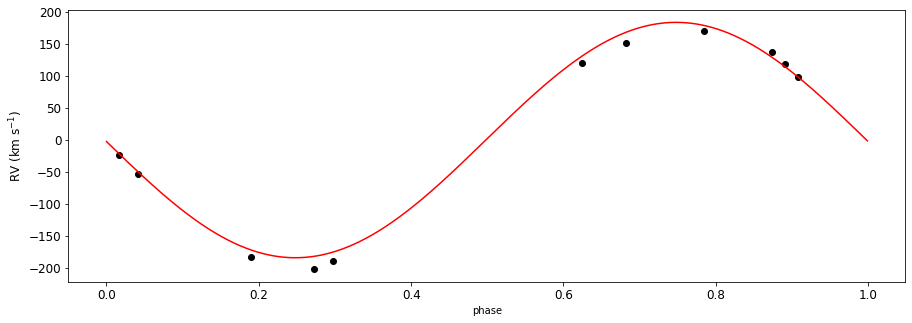

In [14]:
ph = np.arange(0,1,0.001)
rv_model = RV_eq(ph,K_best,theta0_best)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
ax.plot(data['phase'],data['RV_gamma'],'ko')
ax.plot(ph,rv_model,'r-')
ax.set_ylabel(r'RV (km s$^{-1}$)',fontsize=12)
ax.set_xlabel(r'phase')
fig.show()

## Add one more parameter
The more realistic RV is  $RV=K\cos(2\pi p+\theta_0)+RV_{sys}$

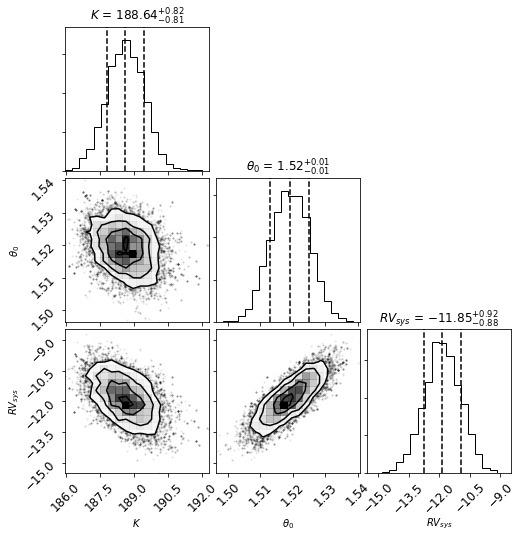

In [15]:
import emcee
import corner

def RV_eq3(ph,K, theta0, RV_sys):
    return K*np.cos(2.*np.pi*ph+theta0)+RV_sys

def lnprob(x, ph, RV,RVerr):
    K = x[0]
    theta0 = x[1]
    RV_sys = x[2]
    if (K<0) or (K>400.) or (theta0<-0) or (theta0>np.pi) or np.abs(RV_sys)>50:
        return -1e50
    else:
        return -np.sum((RV-RV_eq3(ph,K,theta0, RV_sys))**2/(2.*RVerr**2))


ndim = 3

nwalkers = 30

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*100.+150.
p0[:,1] = np.random.rand(nwalkers)*np.pi*2.-np.pi
p0[:,2] = np.random.rand(nwalkers)*100-50
    
sampler = emcee.EnsembleSampler(nwalkers, \
    ndim, lnprob, \
    args=[data['phase'],data['RV_gamma'],data['RV_gamma_error']])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

samples = sampler.chain[:, :, :].reshape((-1, ndim))

ind = (samples[:,0]>0) & (samples[:,0]<400)
fig = corner.corner(samples[ind,:],\
        labels=[r"$K$", r"$\theta_0$",r"$RV_{sys}$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})
K_best = np.median(samples[ind,0])
theta0_best = np.median(samples[ind,1])
RVsys_best = np.median(samples[ind,2])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


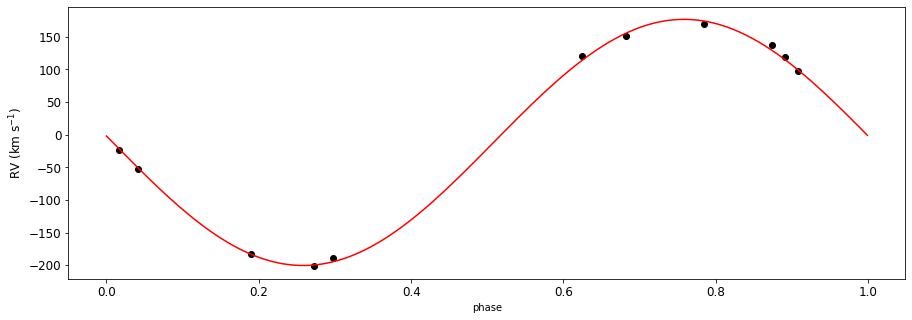

In [17]:
ph = np.arange(0,1,0.001)
rv_model = RV_eq3(ph,K_best,theta0_best,RVsys_best)
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
ax.plot(data['phase'],data['RV_gamma'],'ko')
ax.plot(ph,rv_model,'r-')
ax.set_ylabel(r'RV (km s$^{-1}$)',fontsize=12)
ax.set_xlabel(r'phase')
fig.show()